In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from skimage import measure
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class,generate_data
from GRF_perturbations.Modules.Image_processing import scipy_fit_image,compute_radial_spectrum
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map
from GRF_perturbations.Modules.Inference import distribution_Noise_LogSpectrum,compute_SNR_grid,Inference_pipeline,plot_likelihood,infer_LogNorm_params,compute_Loss_grid,Spectra_Loss,compute_Confidence_grid


#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)

get_GRF=Observation_conditions.GRF_getter
simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
simulate_unperturbed_image_pure=lambda kwargs: simulate_unperturbed_image(kwargs,Noise_flag=False)
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Observation_conditions.annulus_mask,Observation_conditions.init_freq_index)

noise_var=Observation_conditions.noise_var
parameters=Observation_conditions.parameters
Estimated_Noise_spectral_density=(noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()

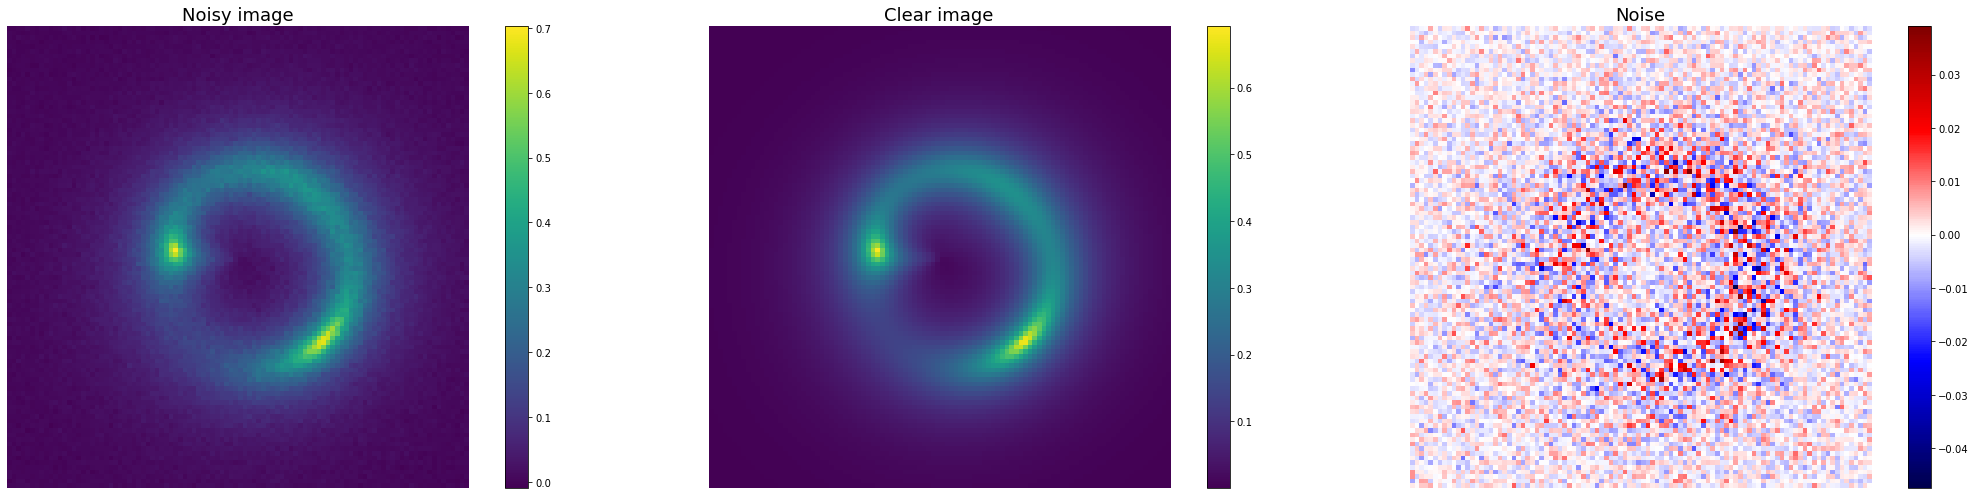

In [3]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)
Image_unperturbed_noisy=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=42)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(Image_unperturbed_noisy)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(Image_unperturbed_noisy-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

In [7]:
get_GRF=Observation_conditions.GRF_getter
extent = Observation_conditions.pixel_grid.extent

# GRF scale

In [147]:
kgrid,dx=get_k_grid_dx(Observation_conditions.pixel_number,Observation_conditions.pixel_scale)
freqs=np.fft.fftshift(np.fft.fftfreq(Observation_conditions.pixel_number,Observation_conditions.pixel_scale))[Observation_conditions.pixel_number//2:]
def power_spectrum(GRF_params,kgrid):
    return np.where(kgrid!=0,np.power(10.,GRF_params[0])*np.power(kgrid,-GRF_params[1]),0)

In [149]:
k_grid,dx=get_k_grid_dx(Observation_conditions.pixel_number,Observation_conditions.pixel_scale)

GRF_params=[-7,2.]
field=get_GRF(GRF_params,1)
PS=power_spectrum(GRF_params,k_grid)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_29880/3547858037.py:4: RuntimeWarning: divide by zero encountered in power
  return np.where(kgrid!=0,np.power(10.,GRF_params[0])*np.power(kgrid,-GRF_params[1]),0)


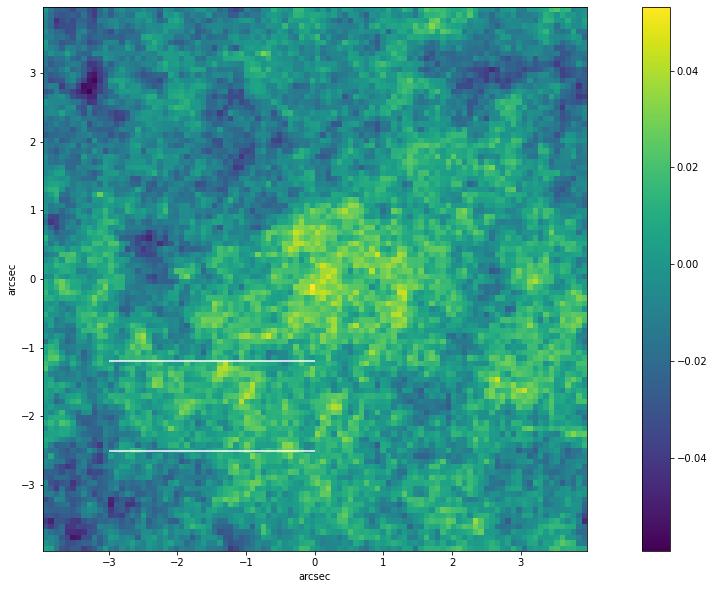

In [150]:
plt.figure(figsize=(20,10))
plt.imshow(field,extent=extent)

plt.hlines(-1.2,-3,0,colors='w')
plt.hlines(-2.5,-3,0,colors='w')

plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.colorbar()

In [162]:
betas=np.linspace(0.1,5,100)
variances=np.zeros((100,100))
total_power=np.zeros((100))

for i,beta in tqdm(enumerate(betas)):
    total_power[i]=power_spectrum([-7,beta],k_grid).sum()
    for j in range(100):
        variances[i,j]=get_GRF([-7,beta],j).std()**2
        

0it [00:00, ?it/s]/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_29880/3547858037.py:4: RuntimeWarning: divide by zero encountered in power
  return np.where(kgrid!=0,np.power(10.,GRF_params[0])*np.power(kgrid,-GRF_params[1]),0)
100it [00:30,  3.31it/s]


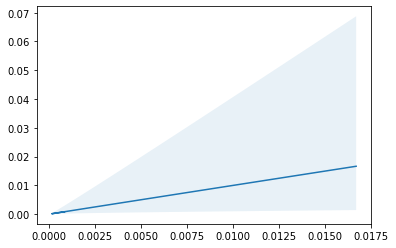

In [166]:
plt.plot(total_power,variances.mean(axis=-1))
plt.fill_between(total_power,variances.min(axis=-1),variances.max(axis=-1),alpha=0.1)

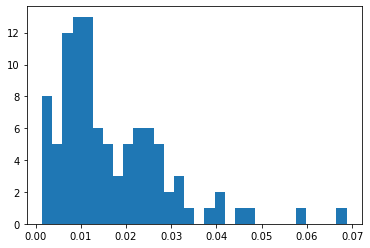

In [177]:
plt.hist(variances[-1],bins=30)
plt.show()

In [167]:
from scipy.optimize import curve_fit

In [174]:
popt,_=curve_fit(lambda power,k,b: k*power+b,total_power,variances.mean(axis=-1))

there is a big variance of generated variance so they should be adjusted

In [175]:
popt

array([1.00059489e+00, 4.49135297e-06])

In [159]:
PS.sum()

0.00017827785140093553

In [153]:
extent

[-3.96, 3.96, -3.96, 3.96]

In [154]:
100*0.08

8.0

In [155]:
3.96*2

7.92

Predicted scale 1.08 arcsec


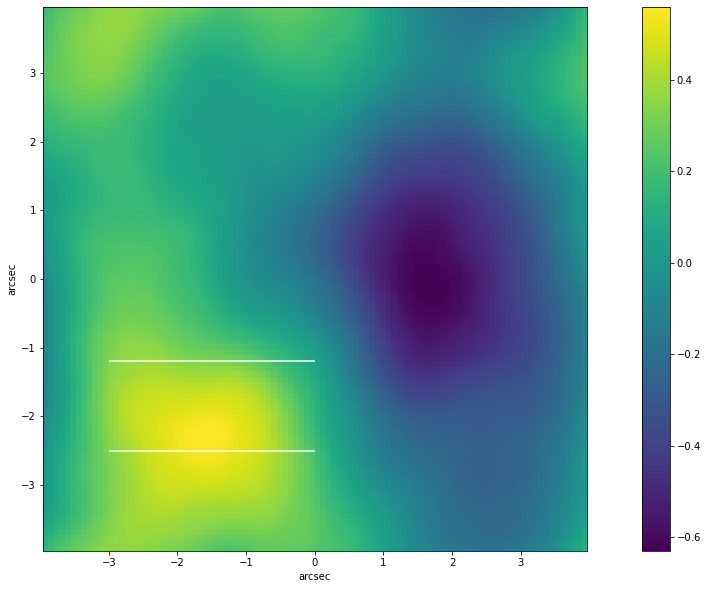

In [140]:
GRF_params=[-7,6.]

field=get_GRF(GRF_params,2)
scale_func= lambda b: ((2*np.pi/(b-2))**(1/b))
print('Predicted scale {:.2f} arcsec'.format(scale_func(GRF_params[1])))
plt.figure(figsize=(20,10))
plt.imshow(field,extent=extent)

plt.hlines(-1.2,-3,0,colors='w')
plt.hlines(-2.5,-3,0,colors='w')

plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.colorbar()

Text(0, 0.5, 'scale')

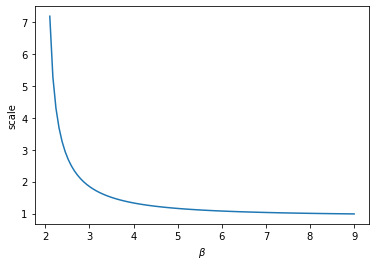

In [83]:
betas=np.linspace(2.1,9,100)
plt.plot(betas,np.vectorize(scale_func)(betas))
plt.xlabel(r'$\beta$')
plt.ylabel('scale')

In [137]:
freqs=np.fft.fftshift(np.fft.fftfreq(Observation_conditions.pixel_number,Observation_conditions.pixel_scale))[Observation_conditions.pixel_number//2:]

In [138]:
1/freqs[20]

0.4

In [25]:
from GRF_perturbations.Modules.GRF_generation import *

In [32]:
freqs=np.fft.fftshift(np.fft.fftfreq(Observation_conditions.pixel_number,Observation_conditions.pixel_scale))[Observation_conditions.pixel_number//2:]

In [33]:
freqs

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
       1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   , 2.125,
       2.25 , 2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   , 3.125, 3.25 ,
       3.375, 3.5  , 3.625, 3.75 , 3.875, 4.   , 4.125, 4.25 , 4.375,
       4.5  , 4.625, 4.75 , 4.875, 5.   , 5.125, 5.25 , 5.375, 5.5  ,
       5.625, 5.75 , 5.875, 6.   , 6.125])

In [34]:
len(freqs)

50

In [36]:
1/0.08/100

0.125

In [141]:
from scipy.signal import correlate2d

In [142]:
q=correlate2d(field,field,'same')

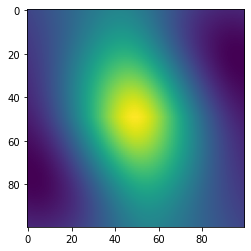

In [143]:
plt.imshow(q)

In [144]:
from GRF_perturbations.Modules.Image_processing import Radial_profile

In [145]:
autocorr_1d=Radial_profile(q,q.shape)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_29880/2648555944.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/freqs,autocorr_1d)


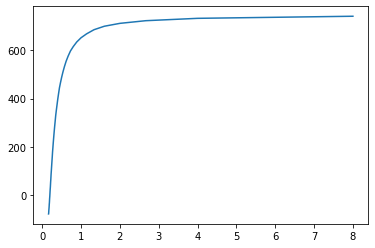

In [146]:
plt.plot(1/freqs,autocorr_1d)

In [90]:
kgrid,dx=get_k_grid_dx(1000,0.008)
freqs=np.fft.fftshift(np.fft.fftfreq(1000,0.008))[1000//2:]
def power_spectrum(GRF_params,kgrid):
    return np.where(kgrid!=0,np.power(10.,GRF_params[0])*np.power(kgrid,-GRF_params[1]),0)

In [104]:
GRF_params

[-7, 3.0]

In [114]:
ps=power_spectrum([-7,6.],kgrid)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_29880/2298231737.py:4: RuntimeWarning: divide by zero encountered in power
  return np.where(kgrid!=0,np.power(10.,GRF_params[0])*np.power(kgrid,-GRF_params[1]),0)


In [115]:
ps_1d=Radial_profile(ps,ps.shape)

In [116]:
ps_1d.mean()

DeviceArray(4.35220585e-05, dtype=float64)

In [117]:
np.argmin(np.abs(ps_1d-ps_1d.mean()))

3

In [120]:
1/freqs[3]

2.6666666666666665

In [119]:
np.argmin(np.abs(ps_1d-ps_1d.mean()))

3

In [103]:
1/freqs[7]

1.1428571428571428

In [134]:
image=get_jaxified_GRF([-7,3],1,1000,0.008)

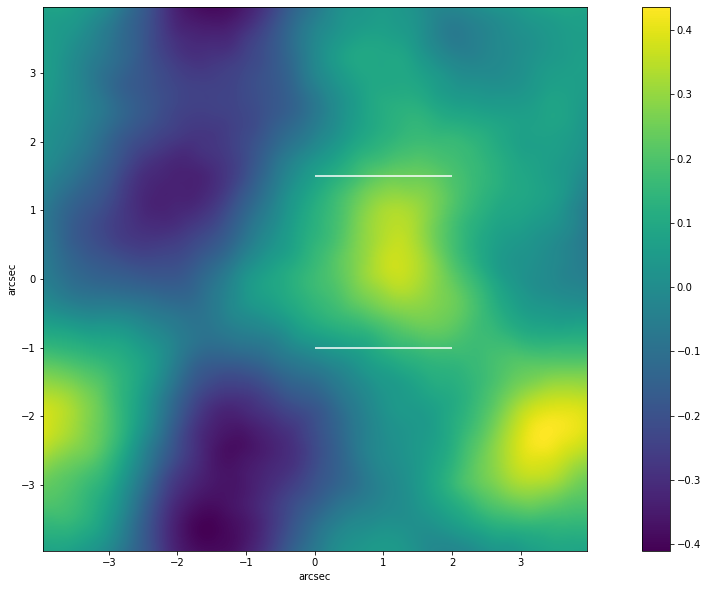

In [123]:
plt.figure(figsize=(20,10))
plt.imshow(image,extent=extent)

plt.hlines(1.5,0,2,colors='w')
plt.hlines(-1,0,2,colors='w')

plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.colorbar()

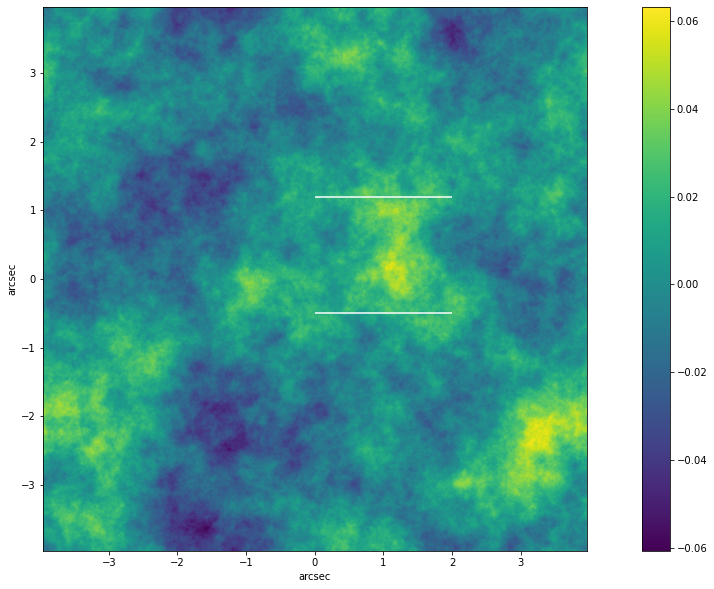

In [136]:
plt.figure(figsize=(20,10))
plt.imshow(image,extent=extent)

plt.hlines(1.2,0,2,colors='w')
plt.hlines(-0.5,0,2,colors='w')

plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.colorbar()

In [126]:
freqs_cut=freqs[1:]

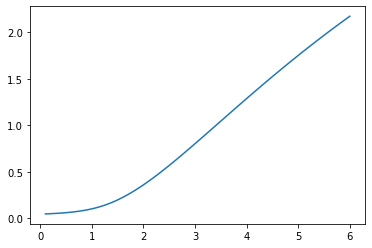

In [133]:
scale_func= lambda b: ((freqs_cut[0]**(1-b)-freqs_cut[-1]**(1-b))/(b-1)/(freqs_cut[-1]-freqs_cut[0]))**(1/b)
plt.plot(np.linspace(0.1,6,100),np.vectorize(scale_func)(np.linspace(0.1,6,100)))

In [132]:
scale_func(0)

1.0

In [128]:
freqs_cut

array([ 0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,  1.   ,
        1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,  2.   ,
        2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875,  3.   ,
        3.125,  3.25 ,  3.375,  3.5  ,  3.625,  3.75 ,  3.875,  4.   ,
        4.125,  4.25 ,  4.375,  4.5  ,  4.625,  4.75 ,  4.875,  5.   ,
        5.125,  5.25 ,  5.375,  5.5  ,  5.625,  5.75 ,  5.875,  6.   ,
        6.125,  6.25 ,  6.375,  6.5  ,  6.625,  6.75 ,  6.875,  7.   ,
        7.125,  7.25 ,  7.375,  7.5  ,  7.625,  7.75 ,  7.875,  8.   ,
        8.125,  8.25 ,  8.375,  8.5  ,  8.625,  8.75 ,  8.875,  9.   ,
        9.125,  9.25 ,  9.375,  9.5  ,  9.625,  9.75 ,  9.875, 10.   ,
       10.125, 10.25 , 10.375, 10.5  , 10.625, 10.75 , 10.875, 11.   ,
       11.125, 11.25 , 11.375, 11.5  , 11.625, 11.75 , 11.875, 12.   ,
       12.125, 12.25 , 12.375, 12.5  , 12.625, 12.75 , 12.875, 13.   ,
       13.125, 13.25 , 13.375, 13.5  , 13.625, 13.75 , 13.875, 14.   ,
      

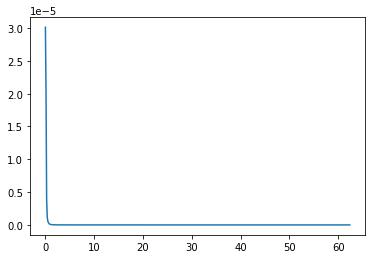

In [94]:
plt.plot(freqs,ps_1d)

In [92]:
len(freqs)

500

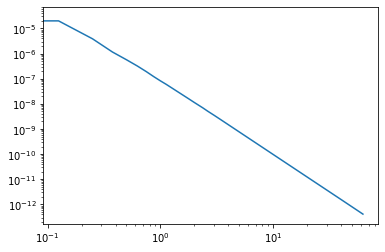

In [91]:
plt.loglog(freqs,ps_1d)

In [68]:
p=np.fft.fft2(q)

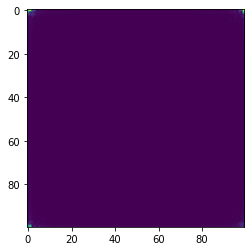

In [71]:
plt.imshow(np.abs(p))